# IMPORTS

In [1]:
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import numpy             as np
import inflection
import math

from matplotlib.gridspec   import GridSpec
from IPython.core.display  import HTML
from boruta                import BorutaPy
from IPython.display       import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from scipy                 import stats
from tabulate              import tabulate
import datetime

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; } </style>'))
    pd.options.display.max_colunms = None
    pd.options.display.max_rows = None
    pd.set_options('display.expand_frame_repr', False)
    
    sns.set()
    
    
    
def cramer_v(x,y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2/(n - 1)
    rcorr = r - (r - 1)**2/(n - 1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr - 1 , rcorr - 1)))   

## Loading Data

In [3]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory = False) #dataframe referência
df_store_raw = pd.read_csv( 'data/store.csv', low_memory = False) #dataframe que será incorporado à referência

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, on = 'Store', how = 'left' )

# Passo1: DESCRIÇÃO DOS DADOS

In [4]:
# Toda vez que mudar de seção é interessante fazer uma cópia do dataset para que, caso ocorra algum erro mais pra frente (tipo sobrescrever dados) não ser preciso rodar todo o notebook novamente.

df1 = df_raw.copy()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Rename columns

- É importante renomear as colunas porque você ganha velocidade no desenvolvimento, colocando nomes mais curtos. Quando vc faz o SQL e traz o dataset para uma base única, os nomes das colunas foram escritos por programadores para facilitar com eles se lembrem deles na hora de trabalhar, mas isso não necessáriamente facilita para quem trabalha com dados. 

- df1.columns  (#está comentado porque poderia ter sido apagado)

- nesse caso, os nomes não estão ruins pq é uma base de dados do Kaggle (que já passou por uma organização. Mas os dados do mundo real não vem assim)

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename
df1.columns = cols_new


## Data Dimensions


In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of cols: {df1.shape[1]}')

Number of rows: 1017209
Number of cols: 18


## Data Types

In [7]:
# A coluna date vem como object. Importante transformá-la para o formato de data.

df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NAs

In [8]:
# Soma de todos os NAs

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

#### Existem 3 forma de lidar com os NAs

    - Não fazer nada, apenas excluí-los. Vantagem: é rápido e simples. Desvantagem: perde-se muita informação;
    - Usando algoritmos de ML que façam essa substituição baseados no comportamento da coluna; 
    - Pensando no negócio - Porque o negócio gerou esses NAs? Criar hipóteses (Meigaron recomenda)

#### competition_distance (distance in meters to the nearest competitor store)

    Assumption: Se a coluna está vazia pode ser porque não tem um competidor próximo ou porque eleestá tão longe que é como se não existisse competição. Vamos assumir que que quando está NA é pq o competidor está tão longe que é como se ele não existisse. Para isso, vamos preencher os NAs com uma distância maior que a distância máxima encontrada na coluna ('75860.0').

In [9]:
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x )

#### competition_open_since_month/year (gives the approximate year and month of the time the nearest competitor was opened)

    Assumption: Existem 2 razões para essa coluna estar vazia: 
    - 1: a loja não tem um competidor mais próximo 
    
    - 2: a loja tem um competidor mais próximo mas a gente não sabe quando ele abriu. Se a competition_open_since_month for NA vamos copiar a data da venda pra essa coluna. Vamos manter essa coluna, pelo menos por enquanto, porque lá na frente ela pode ser necessária para explicar uma queda nas vendas (ocasionada pelo aparecimento de competidor)

In [10]:
# usa axis = 1 para falar que é pra fazer nas colunas. Só precisa usar quando tem mais de uma coluna no código

df1['competition_open_since_month'] = df1[['date', 'competition_open_since_month']].apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1 )

df1['competition_open_since_year'] = df1[['date', 'competition_open_since_year']].apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1 )

#### promo2_since_week/year (describes the year and calendar week when the store started participating in Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating)

    Assumption: se os dados forem NAs quer dizer que a loja decidiu não participar dessa promoção. Substituir o NA pelo valor da data da venda naquela linha

In [11]:
df1['promo2_since_week'] = df1[['date', 'promo2_since_week']].apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis = 1 )

df1['promo2_since_year'] = df1[['date', 'promo2_since_year']].apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis = 1 )

#### promo_interval (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)

    Assumption: Fazer um split dessa coluna e colocar os meses dentro de uma lista. Se a minha data estiver dentro dessa lista, criar uma coluna auxiliar falando que a promoção está ativa. 
                  

In [12]:
# criar coluna auxiliar
month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sept', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change Types

#### É importante checar novamente os tipos das colunas toda vez que a gente faz modificações. É importante também checar coluna por coluna para ver se estão nos tipos corretos.

#### Mudar as colunas 'competition_open_since_month' e 'competition_open_since_year' de float para int, porque tratam do numéro do mês e do ano.

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

#### Mudar as colunas 'promo2_since_week ' e 'promo2_since_year' de float para int, porque tratam do numéro da semana e do ano.

In [15]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive Statistical

#### Para que serve a descrição estatística dos dados?
    - Primeiro: pra gente ganhar conhecimento de negócio;
    - Segundo: pra gente conseguir detectar alguns erros;
    
    Dentro da estatística descritiva existem 2 grandes métricas (de primeira ordem):
    - métricas de tendência central: resumem os dados em um único número (Ex.: média e mediana);
    - métricas de dispersão: dizem se os resultados estão concentrados ou dispersos em relação a média (variância, std, range, min, max);
    
    Outras duas métricas estatísticas:
    - skewness: essencialmente mede a simetria da distribuição;
    - kutosis: determina o peso das caudas de distribuição;

#### Antes de calcular as métricas é preciso separar o conjunto de dados em variáveis numéricas e variáveis categóricas. A estatística descritiva funciona para os dois tipos de variáveis, mas a forma como eu construo a estatística é diferente. Para separar vamos criar dois datasets: um apenas com variáveis categóricas e outro apenas com variáveis numéricas;

In [16]:
num_attributes = df1.select_dtypes(include=[ 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=[ 'int64', 'float64', 'datetime64[ns]' ])

### Numerical Attributes

In [17]:
# Central tendency - mean, median

c1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersion - std, min, máx, range, skew, kurtosis 
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [ d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


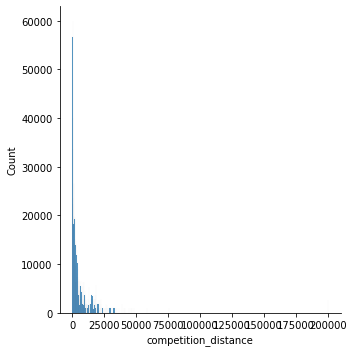

In [18]:
sns.displot( df1['competition_distance'])

### Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

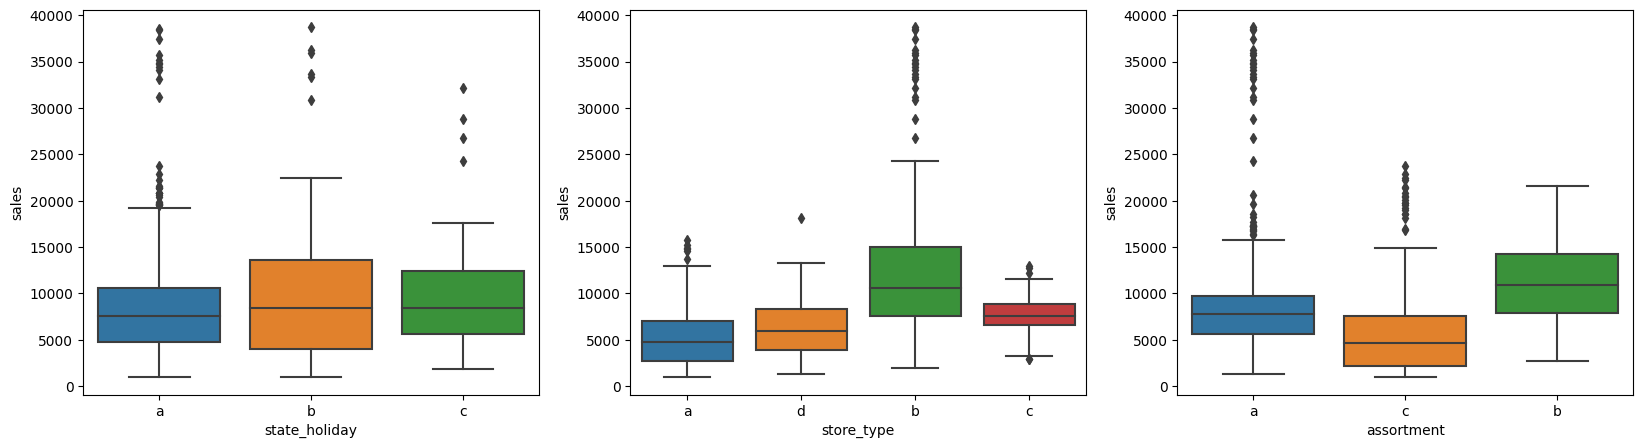

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] >0)]

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday' ,y = 'sales' ,data = aux1 )

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type' ,y = 'sales' ,data = aux1 )

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment' ,y = 'sales' ,data = aux1 )


# Passo2: FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## Mapa mental de hipóteses

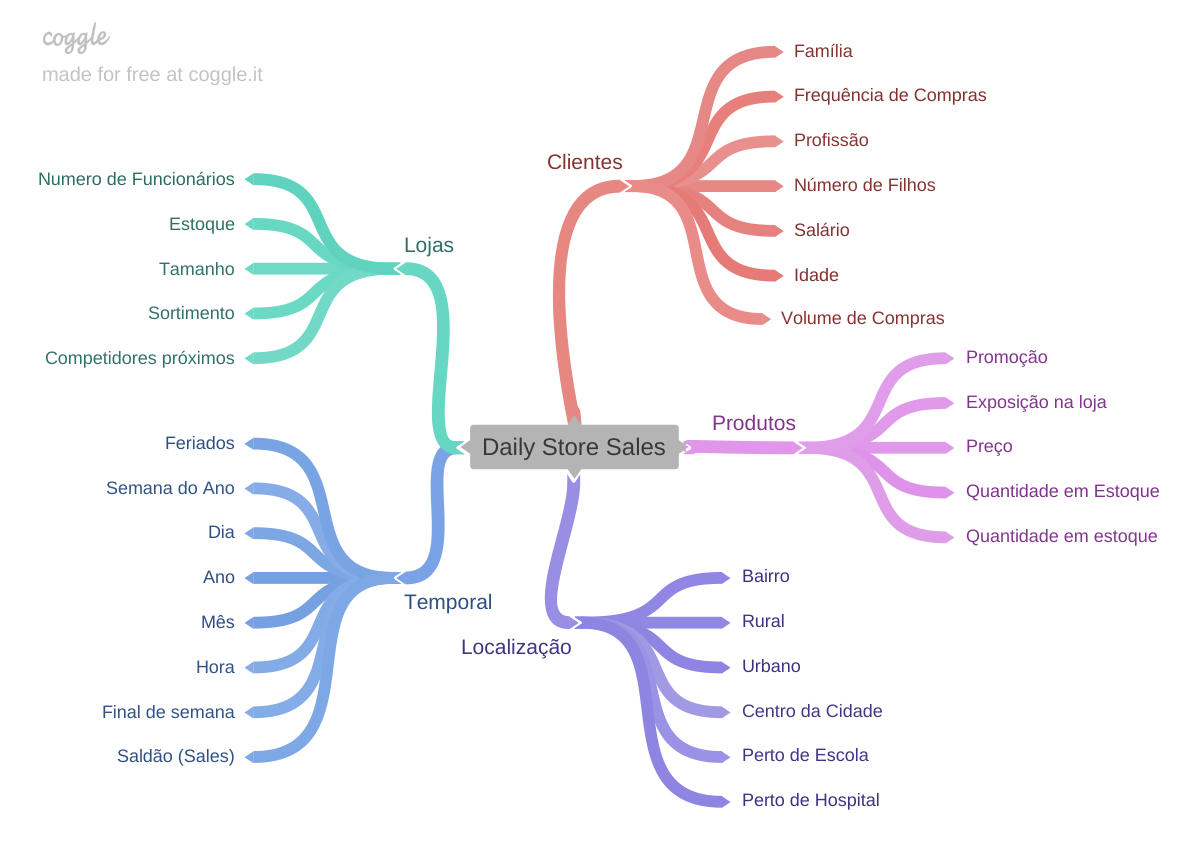

In [22]:
Image( 'img/mind_map_hypotesis.png' )

## Criação das hipóteses

### Hipóteses relacionadas a 'Lojas'

**1.** Lojas com maior quadro de funcionários deveriam vender mais;

**2.** Lojas com maior capacidade de estoque deveriam vender mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com maior sortimento deveriam vender mais;

**5.** Lojas com competidores mais próximos deveriam vender menos;

**6.** Lojas com competidores há mais tempo deveriam vender mais;

### Hipóteses relacionadas a 'Produtos'

**1.** Lojas que investem mais em marketing deveriam vender mais;

**2.** Lojas com maior exposição de produtos deveriam vender mais;

**3.** Lojas que têm preços menores nos produtos deveriam vender mais;

**4.** Lojas com promoções mais agressivas (maiores descontos) deveriam vender mais; 

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais; 

**6.** Lojas com mais dias de promoção deveriam vender mais;

**7.** Lojas com mais promoções consecutivas deveriam vender mais;

### Hipóteses relacionadas a 'Tempo'

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender menos aos finais de semana;

**6.** Lojas deveriam vender menos durante os feriados escolares;

## Lista final das hipóteses

###### Listar aquelas para as quais eu tenho os dados:

**1.** Lojas com maior sortimento deveriam vender mais;

**2.** Lojas com competidores mais próximos deveriam vender menos;

**3.** Lojas com competidores há mais tempo deveriam vender mais;


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais; 

**5.** Lojas com mais dias de promoção deveriam vender mais;

**6.** Lojas com mais promoções consecutivas deveriam vender mais;


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**8.** Lojas deveriam vender mais ao longo dos anos;

**9.** Lojas deveriam vender mais no segundo semestre do ano;

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**11.** Lojas deveriam vender menos aos finais de semana;

**12.** Lojas deveriam vender menos durante os feriados escolares;


## Feature Engineering

In [23]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


In [24]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis=1)

In [25]:
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30).apply( lambda x: x.days).astype( int )

In [26]:
#promo since

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))

df2['promo_time_week'] = ( (df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype( int )

In [27]:
#assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [28]:
#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [29]:
df2.sample(10).T

,773740,457114,564516,767179,842379,350552,113302,143323,920519,209385
store,716,750,1112,845,225,122,688,604,315,881
day_of_week,3,7,2,2,4,7,2,3,4,7
date,2013-08-07 00:00:00,2014-05-18 00:00:00,2014-02-11 00:00:00,2013-08-13 00:00:00,2013-06-06 00:00:00,2014-08-31 00:00:00,2015-04-21 00:00:00,2015-03-25 00:00:00,2013-03-28 00:00:00,2015-01-25 00:00:00
sales,4591,0,7149,5339,5581,4146,2789,5347,7577,0
customers,392,0,684,367,646,513,336,432,718,0
open,1,0,1,1,1,1,1,1,1,0
promo,0,0,0,1,1,0,0,0,1,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,0,0,1,0,0,0,0,1,0
store_type,d,d,c,d,d,a,a,d,a,a


# Passo3: FILTRAGEM DE VARIÁVEIS

In [30]:
df3 = df2.copy()
df3.shape

(1017209, 29)

## Filtragem das linhas 

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.shape

(844338, 29)

## Seleção das colunas 

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )
df3.shape

(844338, 25)

# Passo4: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

In [33]:
df4 = df3.copy()

## Análise Univariada

### Response Variable

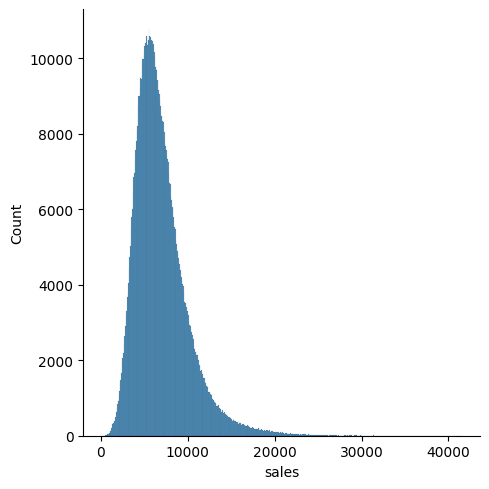

In [34]:
sns.displot( df4['sales'] )

### Numerical Variable

In [35]:
num_attributes1 = df4.select_dtypes(include=[ 'int64', 'float64'])
cat_attributes1 = df4.select_dtypes(exclude=[ 'int64', 'float64', 'datetime64[ns]' ])

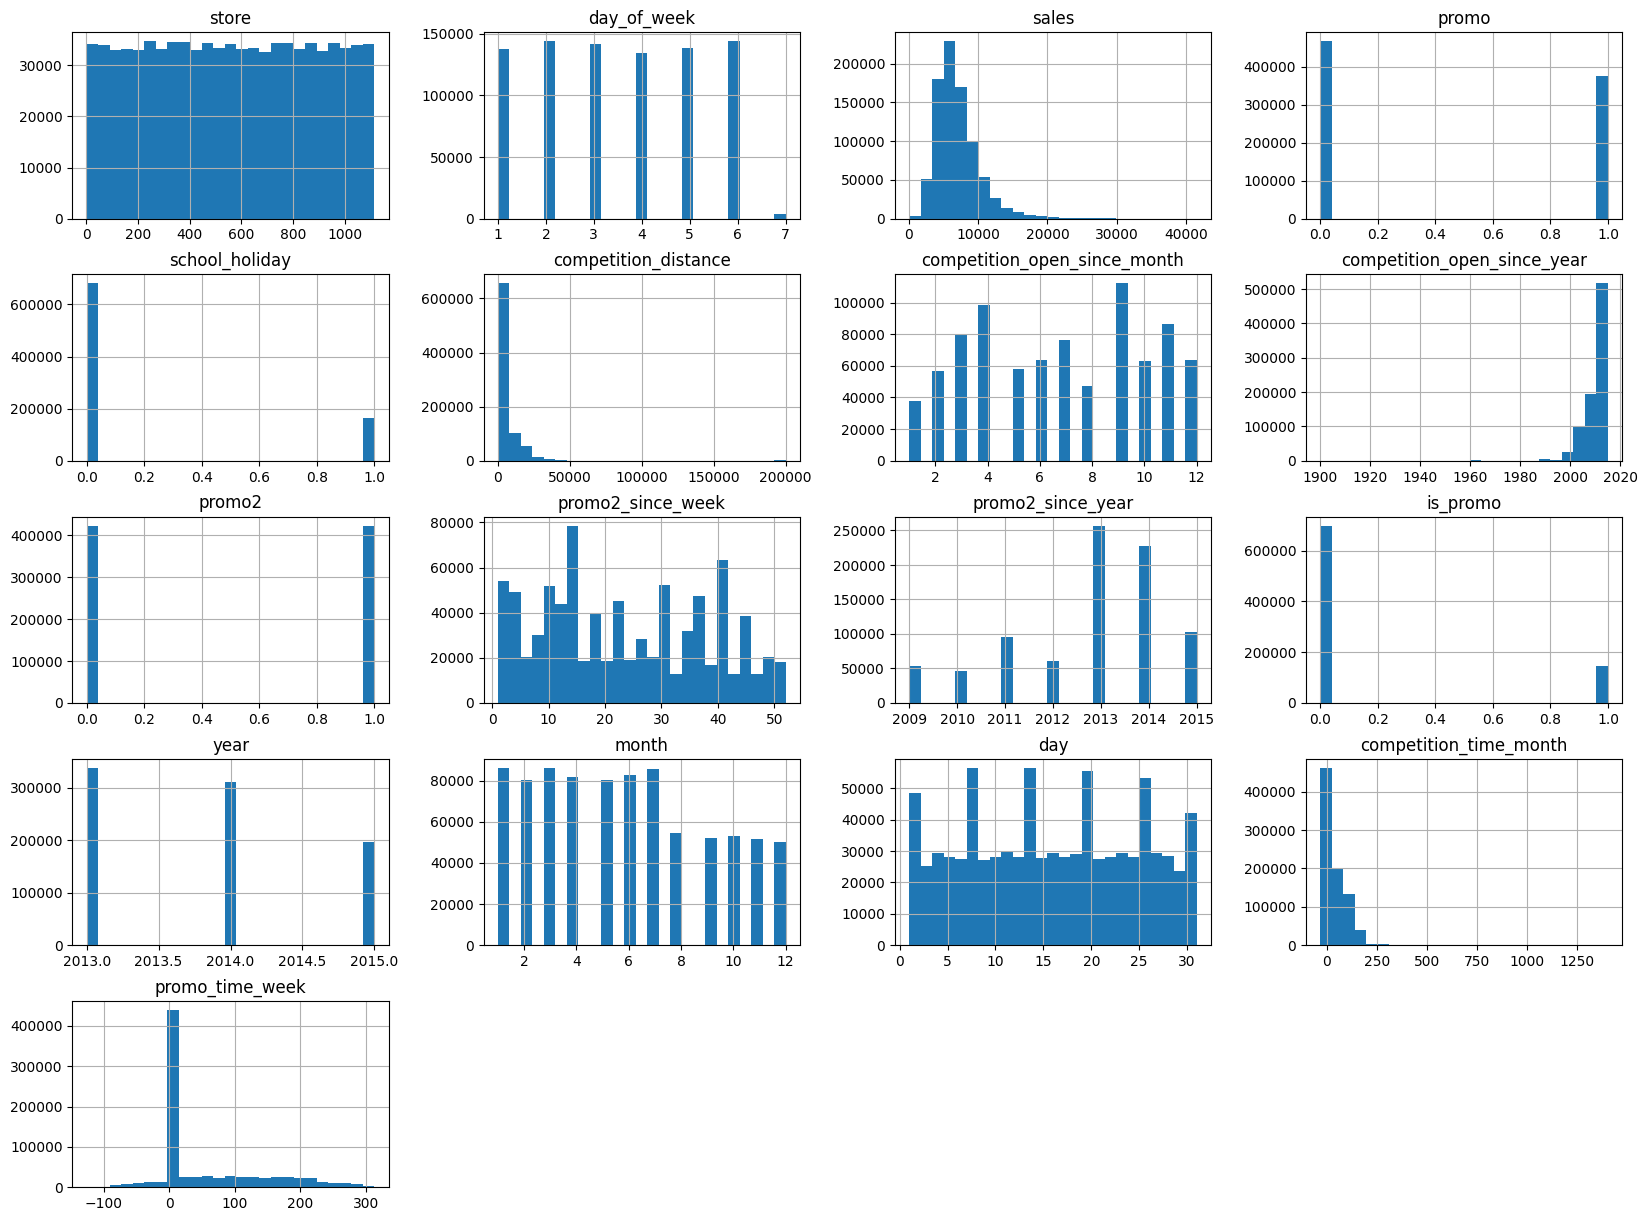

In [36]:
num_attributes1.hist( bins = 25, figsize=(20,15));

### Categorical Variable

In [37]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [38]:
# State Holiday

df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

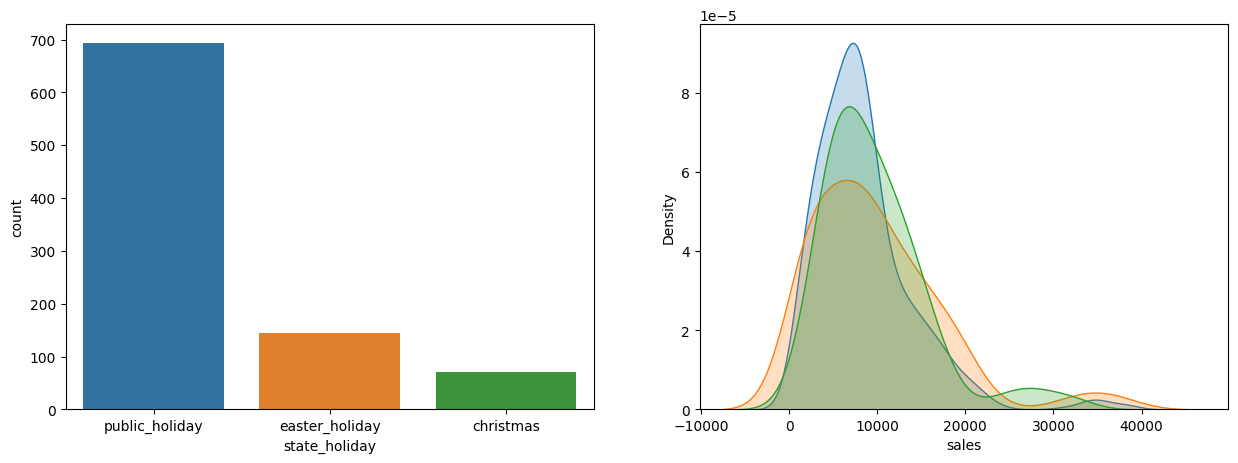

In [39]:
plt.figure(figsize=(15, 5))

plt.subplot( 1, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( x=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True,  legend=True)
sns.kdeplot( x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True,  legend=True)
sns.kdeplot( x=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True, legend=True)

In [40]:
# store_type

df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

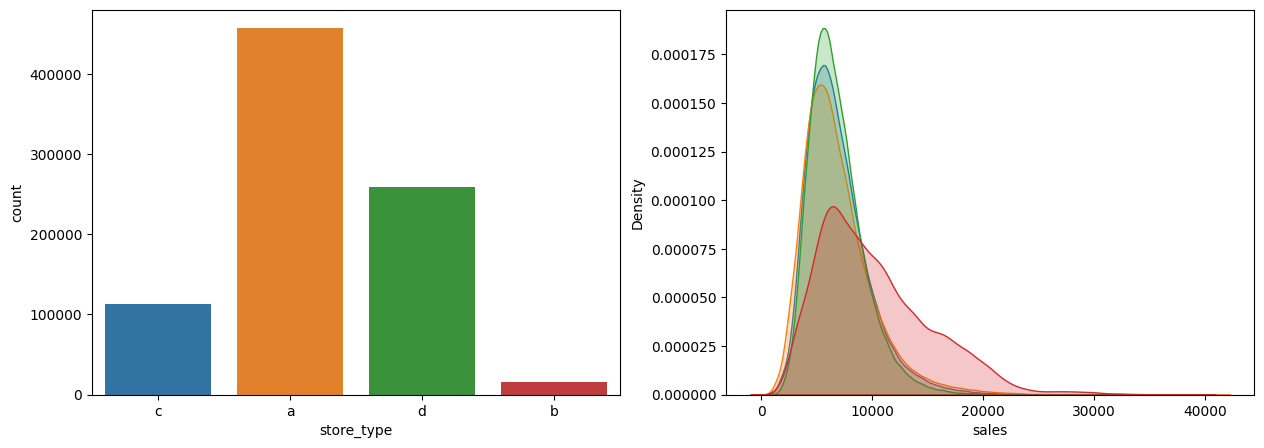

In [41]:
plt.figure(figsize=(15, 5))

plt.subplot( 1, 2, 1 )
sns.countplot( x=df4['store_type'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( x=df4[df4['store_type'] == 'c']['sales'], label='c', shade=True,  legend=True)
sns.kdeplot( x=df4[df4['store_type'] == 'a']['sales'], label='a', shade=True,  legend=True)
sns.kdeplot( x=df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, legend=True)
sns.kdeplot( x=df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, legend=True)

In [42]:
# assortment

df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

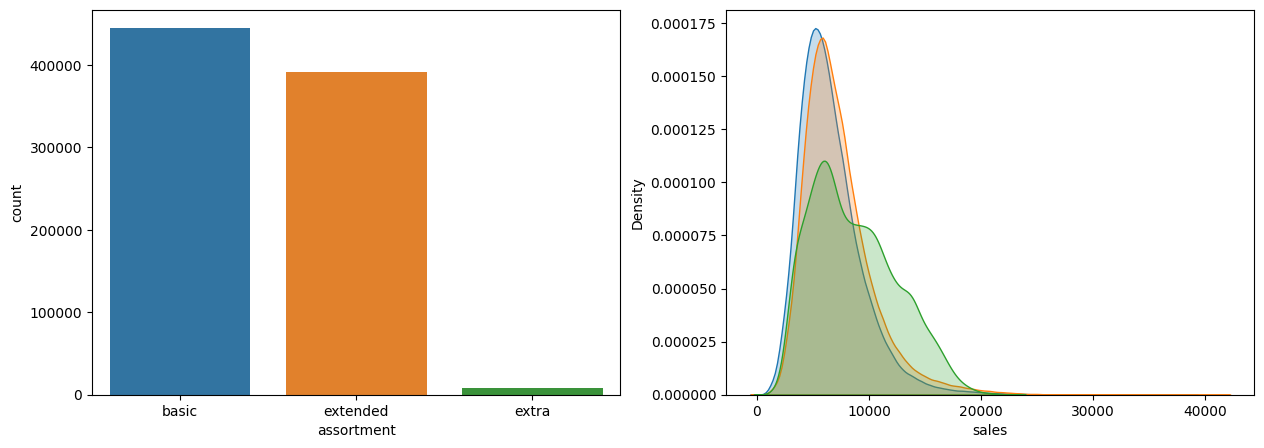

In [43]:
plt.figure(figsize=(15, 5))

plt.subplot( 1, 2, 1 )
sns.countplot( x=df4['assortment'] )

plt.subplot( 1, 2, 2 )
sns.kdeplot( x=df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True,  legend=True)
sns.kdeplot( x=df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True,  legend=True)
sns.kdeplot( x=df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, legend=True)


## Análise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais;

**Verdadeira** Lojas com MAIOR SORTIMENTO vendem MAIS. Precisa olhar a média (vendas dividido pela quantidade de loja) para saber essa resposta.

<AxesSubplot:xlabel='year_week'>

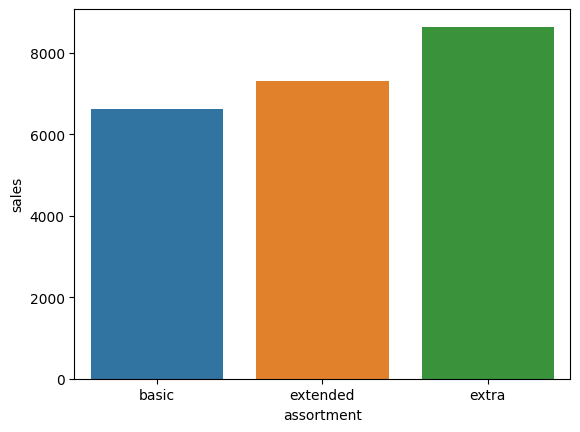

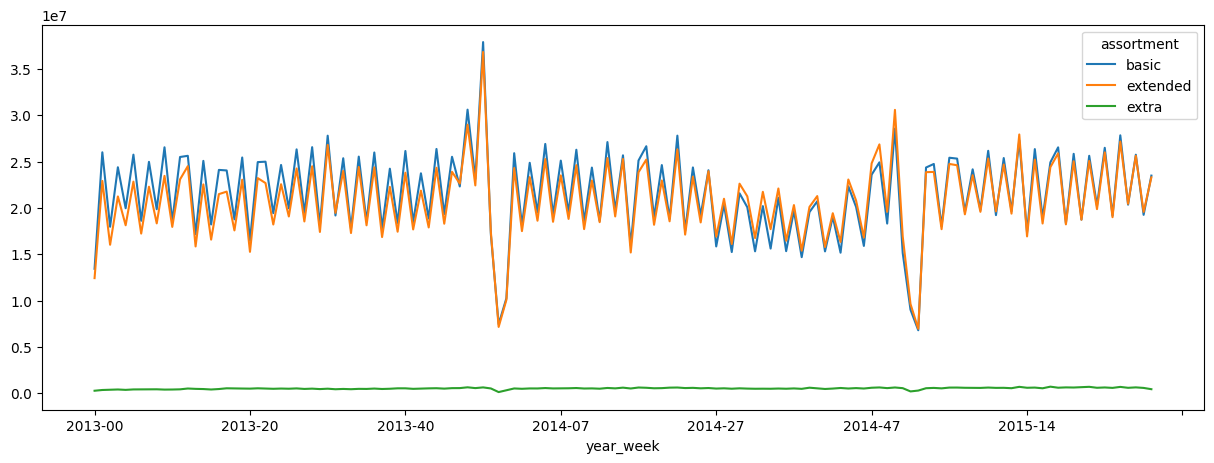

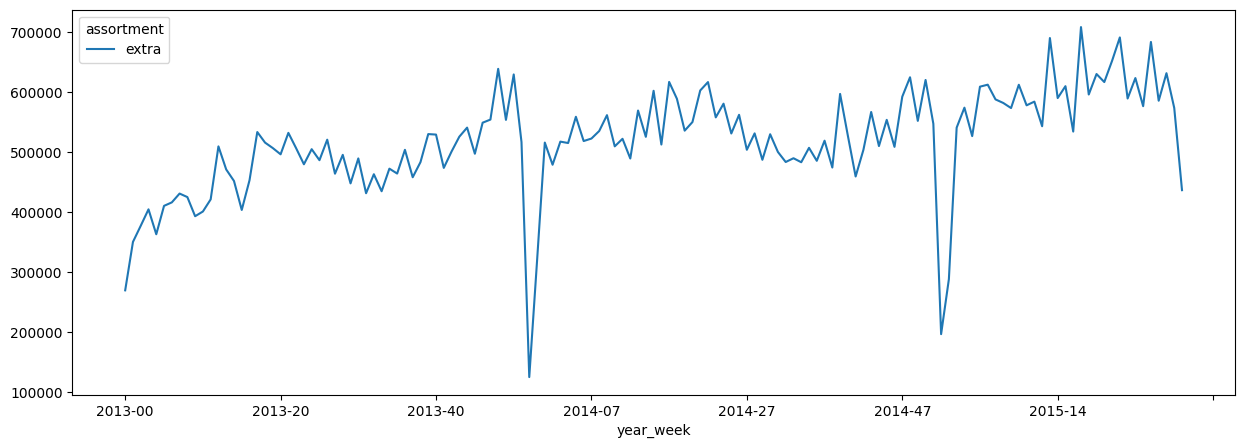

In [44]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize=(15, 5))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot( figsize=(15,5))

### **H2.** Lojas com competidores mais próximos deveriam vender menos;

**Falsa** A distância MEDIANA dos competidores em relação às lojas NÃO interfere na quantidade de vendas.

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

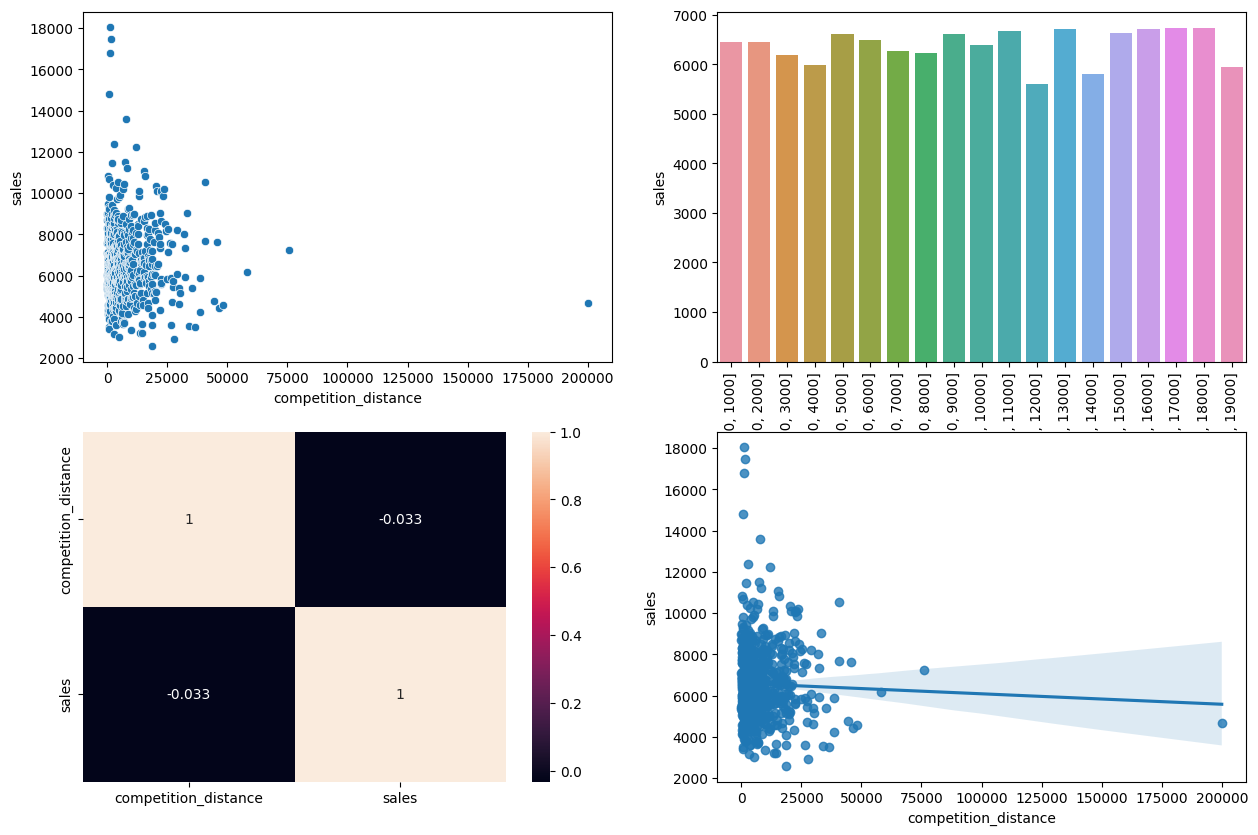

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()

plt.figure(figsize=(15, 10))

plt.subplot( 2, 2, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot( 2, 2, 2)
bins = list( np.arange( 0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').median().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation = 90 )

plt.subplot( 2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);

plt.subplot( 2, 2, 4)
sns.regplot( x='competition_distance', y='sales', data=aux1)


### **H3.** Lojas com competidores há mais tempo deveriam vender mais;

**Verdadeira** Quanto MAIOR o tempo de abertura dos competidores MAIORES são as vendas.

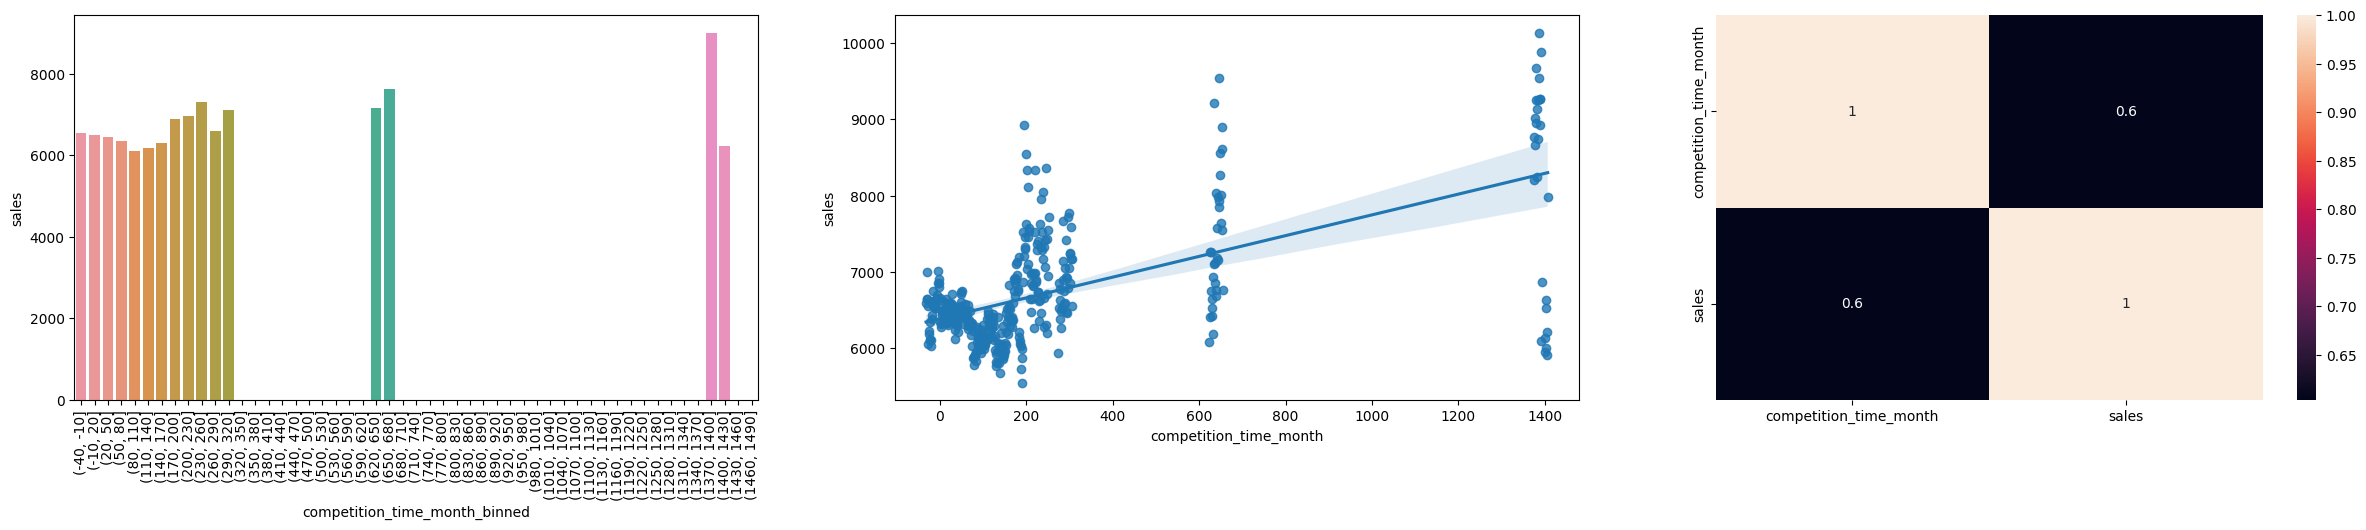

In [46]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()

plt.figure(figsize=(30, 5));

plt.subplot( 1, 3, 1)
bins = list( np.arange( -40, 1500, 30));
aux1['competition_time_month_binned'] = pd.cut( aux1['competition_time_month'], bins=bins);
aux2 = aux1[['competition_time_month_binned', 'sales']].groupby( 'competition_time_month_binned').median().reset_index();
sns.barplot( x='competition_time_month_binned', y='sales', data=aux2);
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux1);

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais; 


**Verdadeira** A permanência em promoção influencia as vendas positivamente, embora seja em pouca intensidade.

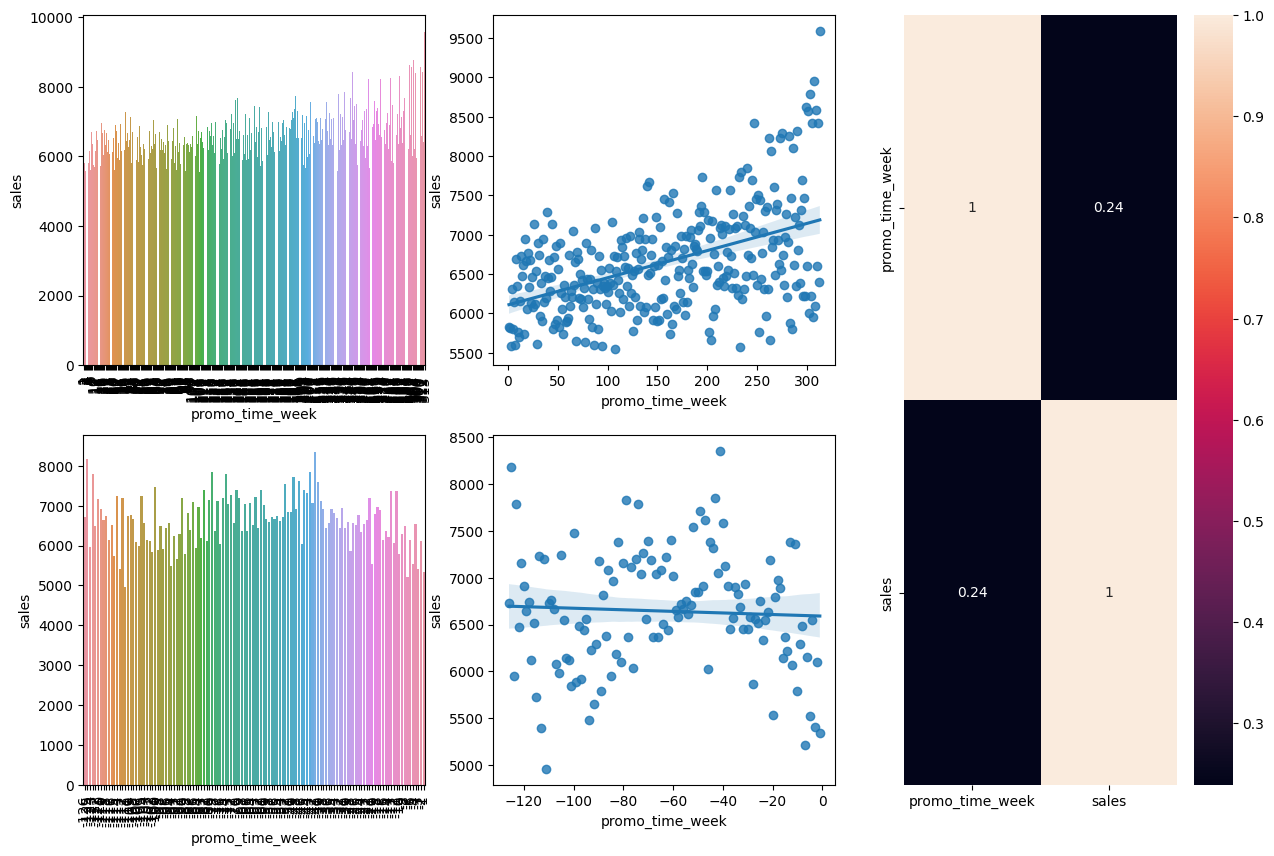

In [47]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
plt.figure(figsize=(15, 10));

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendida
sns.barplot( x = 'promo_time_week', y = 'sales', data=aux2)
plt.xticks( rotation = 90 );

plt.subplot(grid[0,1])
sns.regplot( x = 'promo_time_week', y = 'sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot( x = 'promo_time_week', y = 'sales', data=aux3)
plt.xticks( rotation = 90 );

plt.subplot(grid[1,1])
sns.regplot( x = 'promo_time_week', y = 'sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais </s>

- Muito parecida com a hipótese 4. Para avaliá-la seria necessário derivar um feature no dataset para ter a informação de dias de promoção. Isso será feito no pŕoximo ciclo do crisp.

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais;

**Falsa** Lojas que participam de promoções consecutivas NÃO vendem mais.

In [48]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


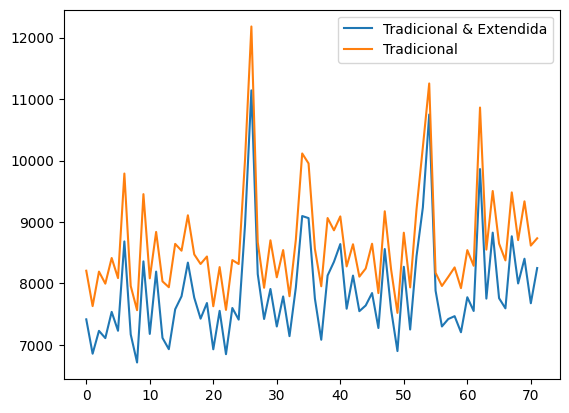

In [49]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Tradicional'])


### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais;


**Inconclusiva** Não tem como validar esse hipótese porque faltam os dados do feriado de natal do ano de 2015.

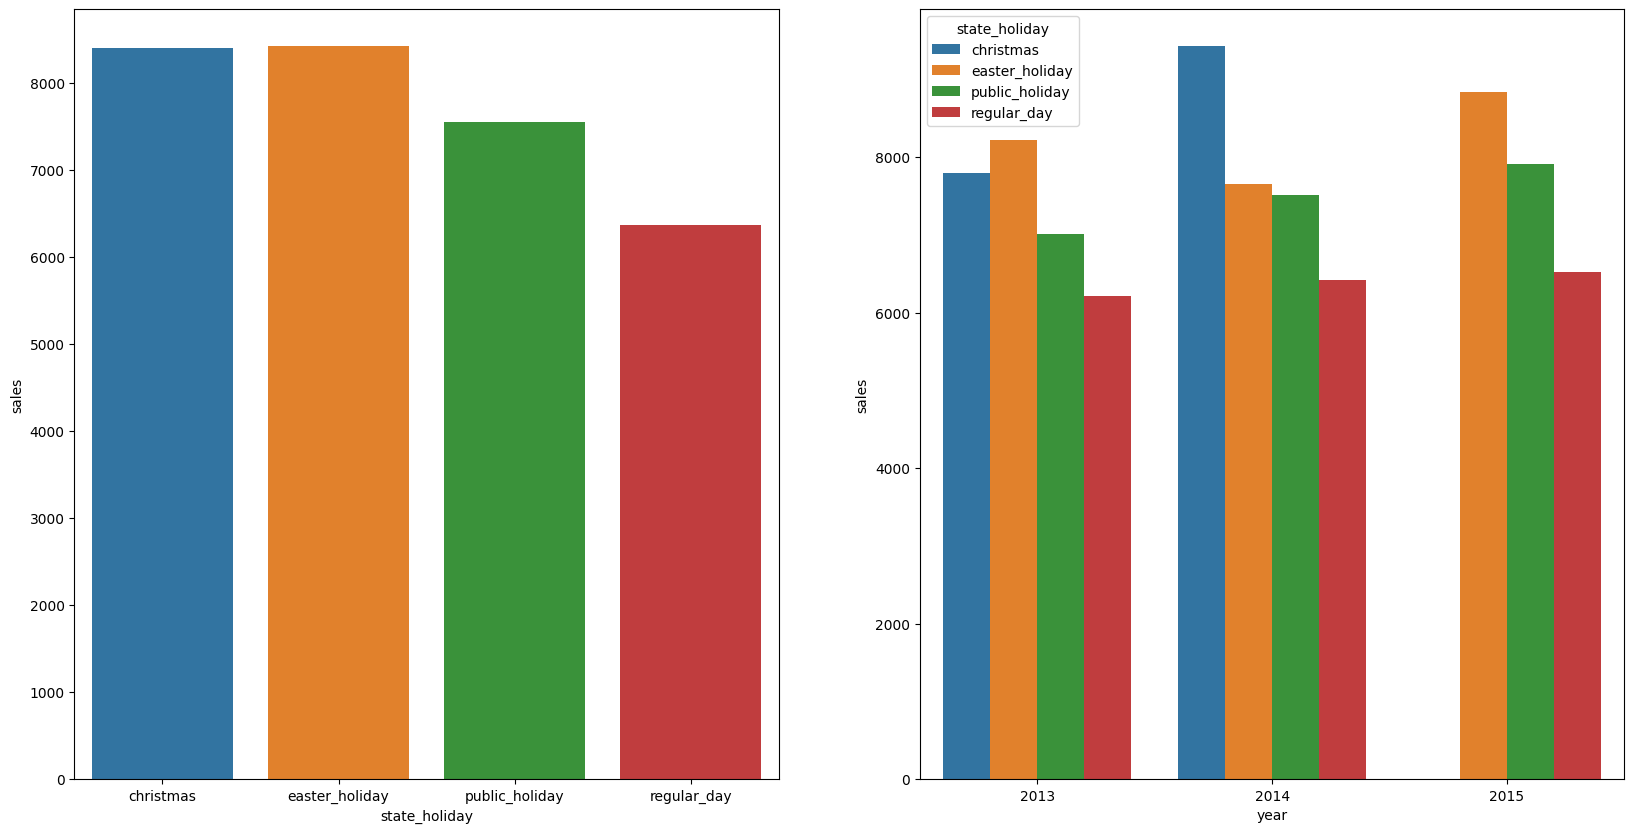

In [50]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
aux1 = df4[['state_holiday', 'sales']].groupby(['state_holiday']).median().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).median().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);


### **H8.** Lojas deveriam vender mais ao longo dos anos;

**Verdadeira** Lojas vendem MAIS ao longo dos anos.

<AxesSubplot:>

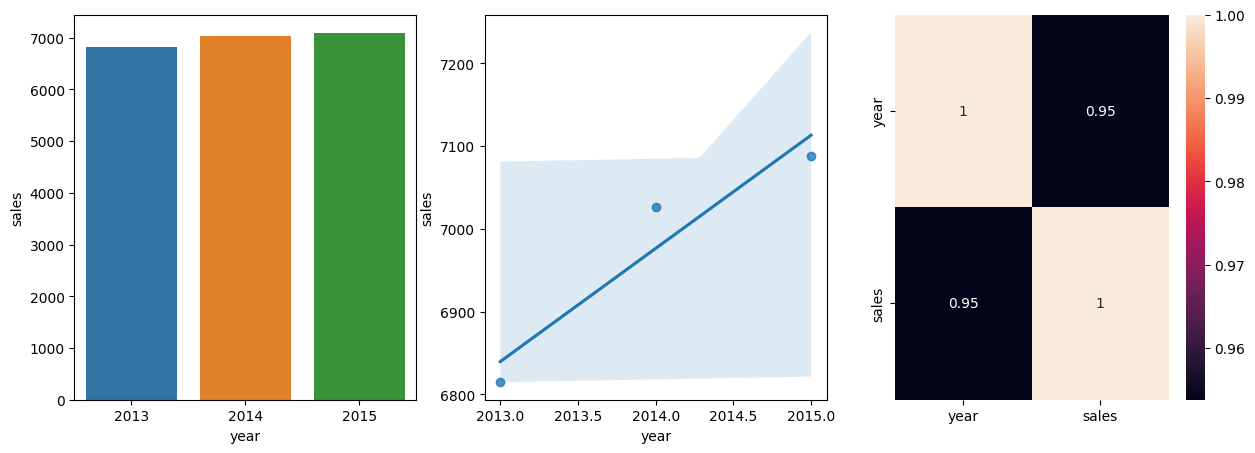

In [51]:
aux1 = df4[['year','sales']].groupby('year').mean().reset_index()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot( x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot( x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)



### **H9.** Lojas deveriam vender mais no segundo semestre do ano;

**Verdadeira** Lojas vendem MAIS no segundo semestre do ano.

<AxesSubplot:>

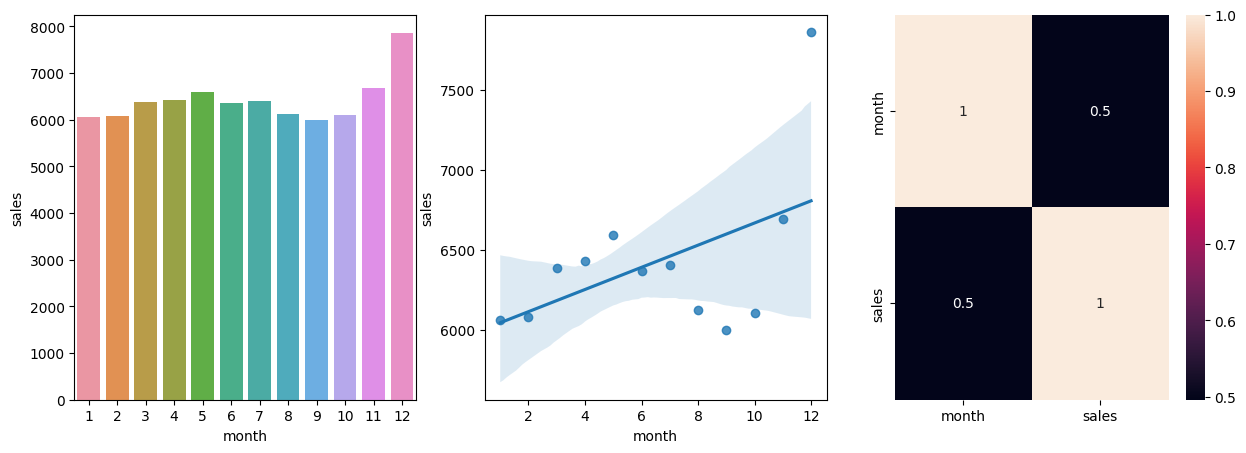

In [52]:
aux1 = df4[['month','sales']].groupby('month').median().reset_index()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.barplot( x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot( x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**Falsa** Lojas vendem MAIS antes do dia 10 de cada mês.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

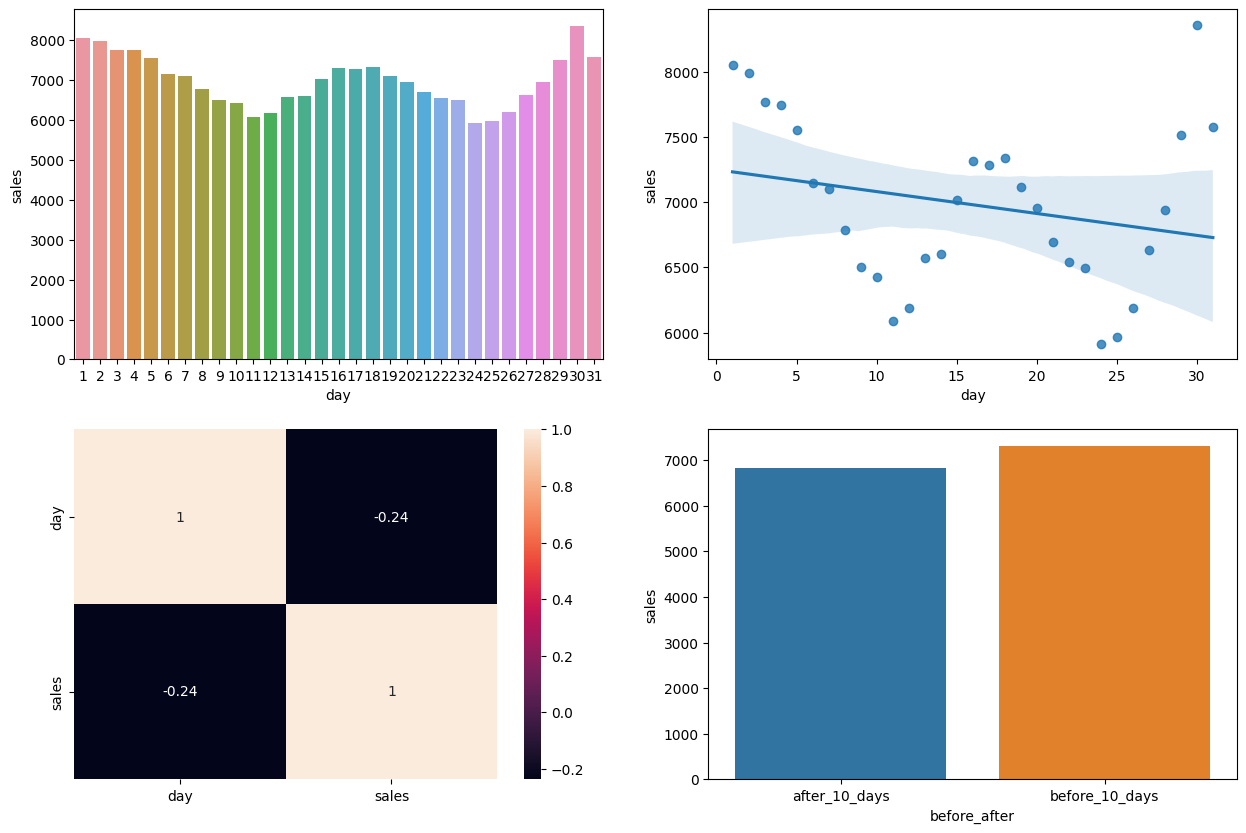

In [53]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.barplot( x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot( x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2)



### **H11.** Lojas deveriam vender menos aos finais de semana;

**Verdadeira** Lojas vendem ligeiramente MENOS nos finais de semana.

<AxesSubplot:xlabel='week_weekends', ylabel='sales'>

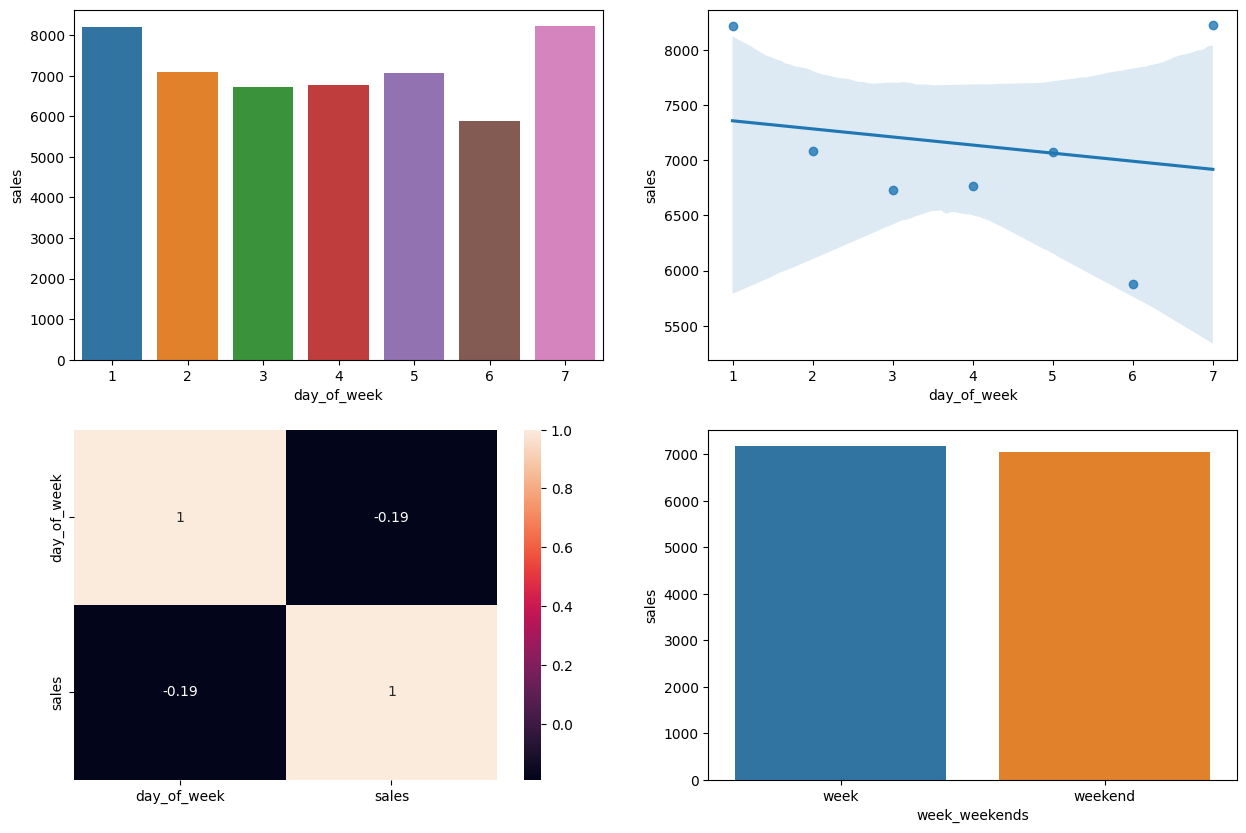

In [54]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').mean().reset_index()

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.barplot( x='day_of_week', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot( x='day_of_week', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True)

plt.subplot(2,2,4)
aux1['week_weekends'] = aux1['day_of_week'].apply(lambda x: 'week' if x <= 5 else 'weekend')
aux2 = aux1[['week_weekends', 'sales']].groupby('week_weekends').mean().reset_index()
sns.barplot( x='week_weekends', y='sales', data=aux2)


### **H12.** Lojas deveriam vender menos durante os feriados escolares;

**Falso** Lojas vendem MAIS durante os feriados escolares.

<AxesSubplot:xlabel='month', ylabel='sales'>

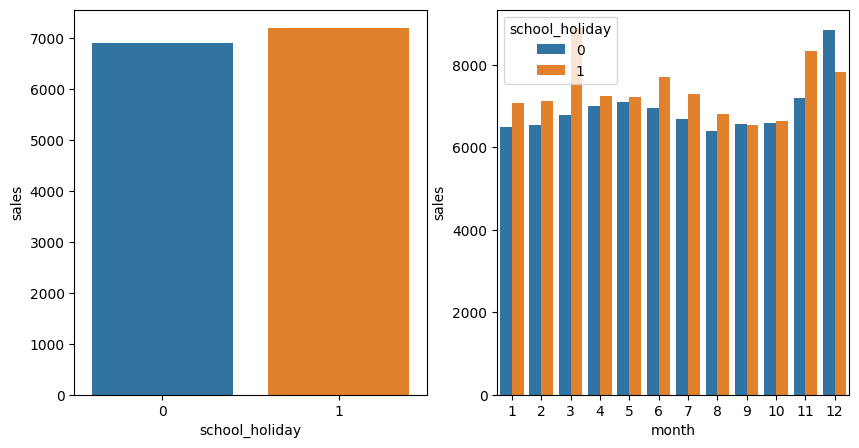

In [55]:
plt.figure(figsize=(10,5))

aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
plt.subplot(1,2,1)
sns.barplot( x='school_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2)


### Resumo das hipóteses

In [68]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Verdadeira', 'Alta' ],
      ['H2', 'Falsa', 'Baixa' ],
      ['H3', 'Verdadeira', 'Alta' ],
      ['H4', 'Verdadeira', 'Alta' ],
      ['H5', 'Não fez', 'Não fez' ],
      ['H6', 'Falsa', 'Baixa' ],
      ['H7', 'Inconclusiva', 'Baixa' ],
      ['H8', 'Verdadeira', 'Alta' ],
      ['H9', 'Verdadeira', 'Média' ],
      ['H10', 'Falsa', 'Média' ],
      ['H11', 'Verdadeira', 'Média' ],
      ['H12', 'Falsa', 'Baixa' ]]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão     Relevância
-----------  ------------  ------------
H1           Verdadeira    Alta
H2           Falsa         Baixa
H3           Verdadeira    Alta
H4           Verdadeira    Alta
H5           Não fez       Não fez
H6           Falsa         Baixa
H7           Inconclusiva  Baixa
H8           Verdadeira    Alta
H9           Verdadeira    Média
H10          Falsa         Média
H11          Verdadeira    Média
H12          Falsa         Baixa


## Análise Multivariada

### Numerical Attributes

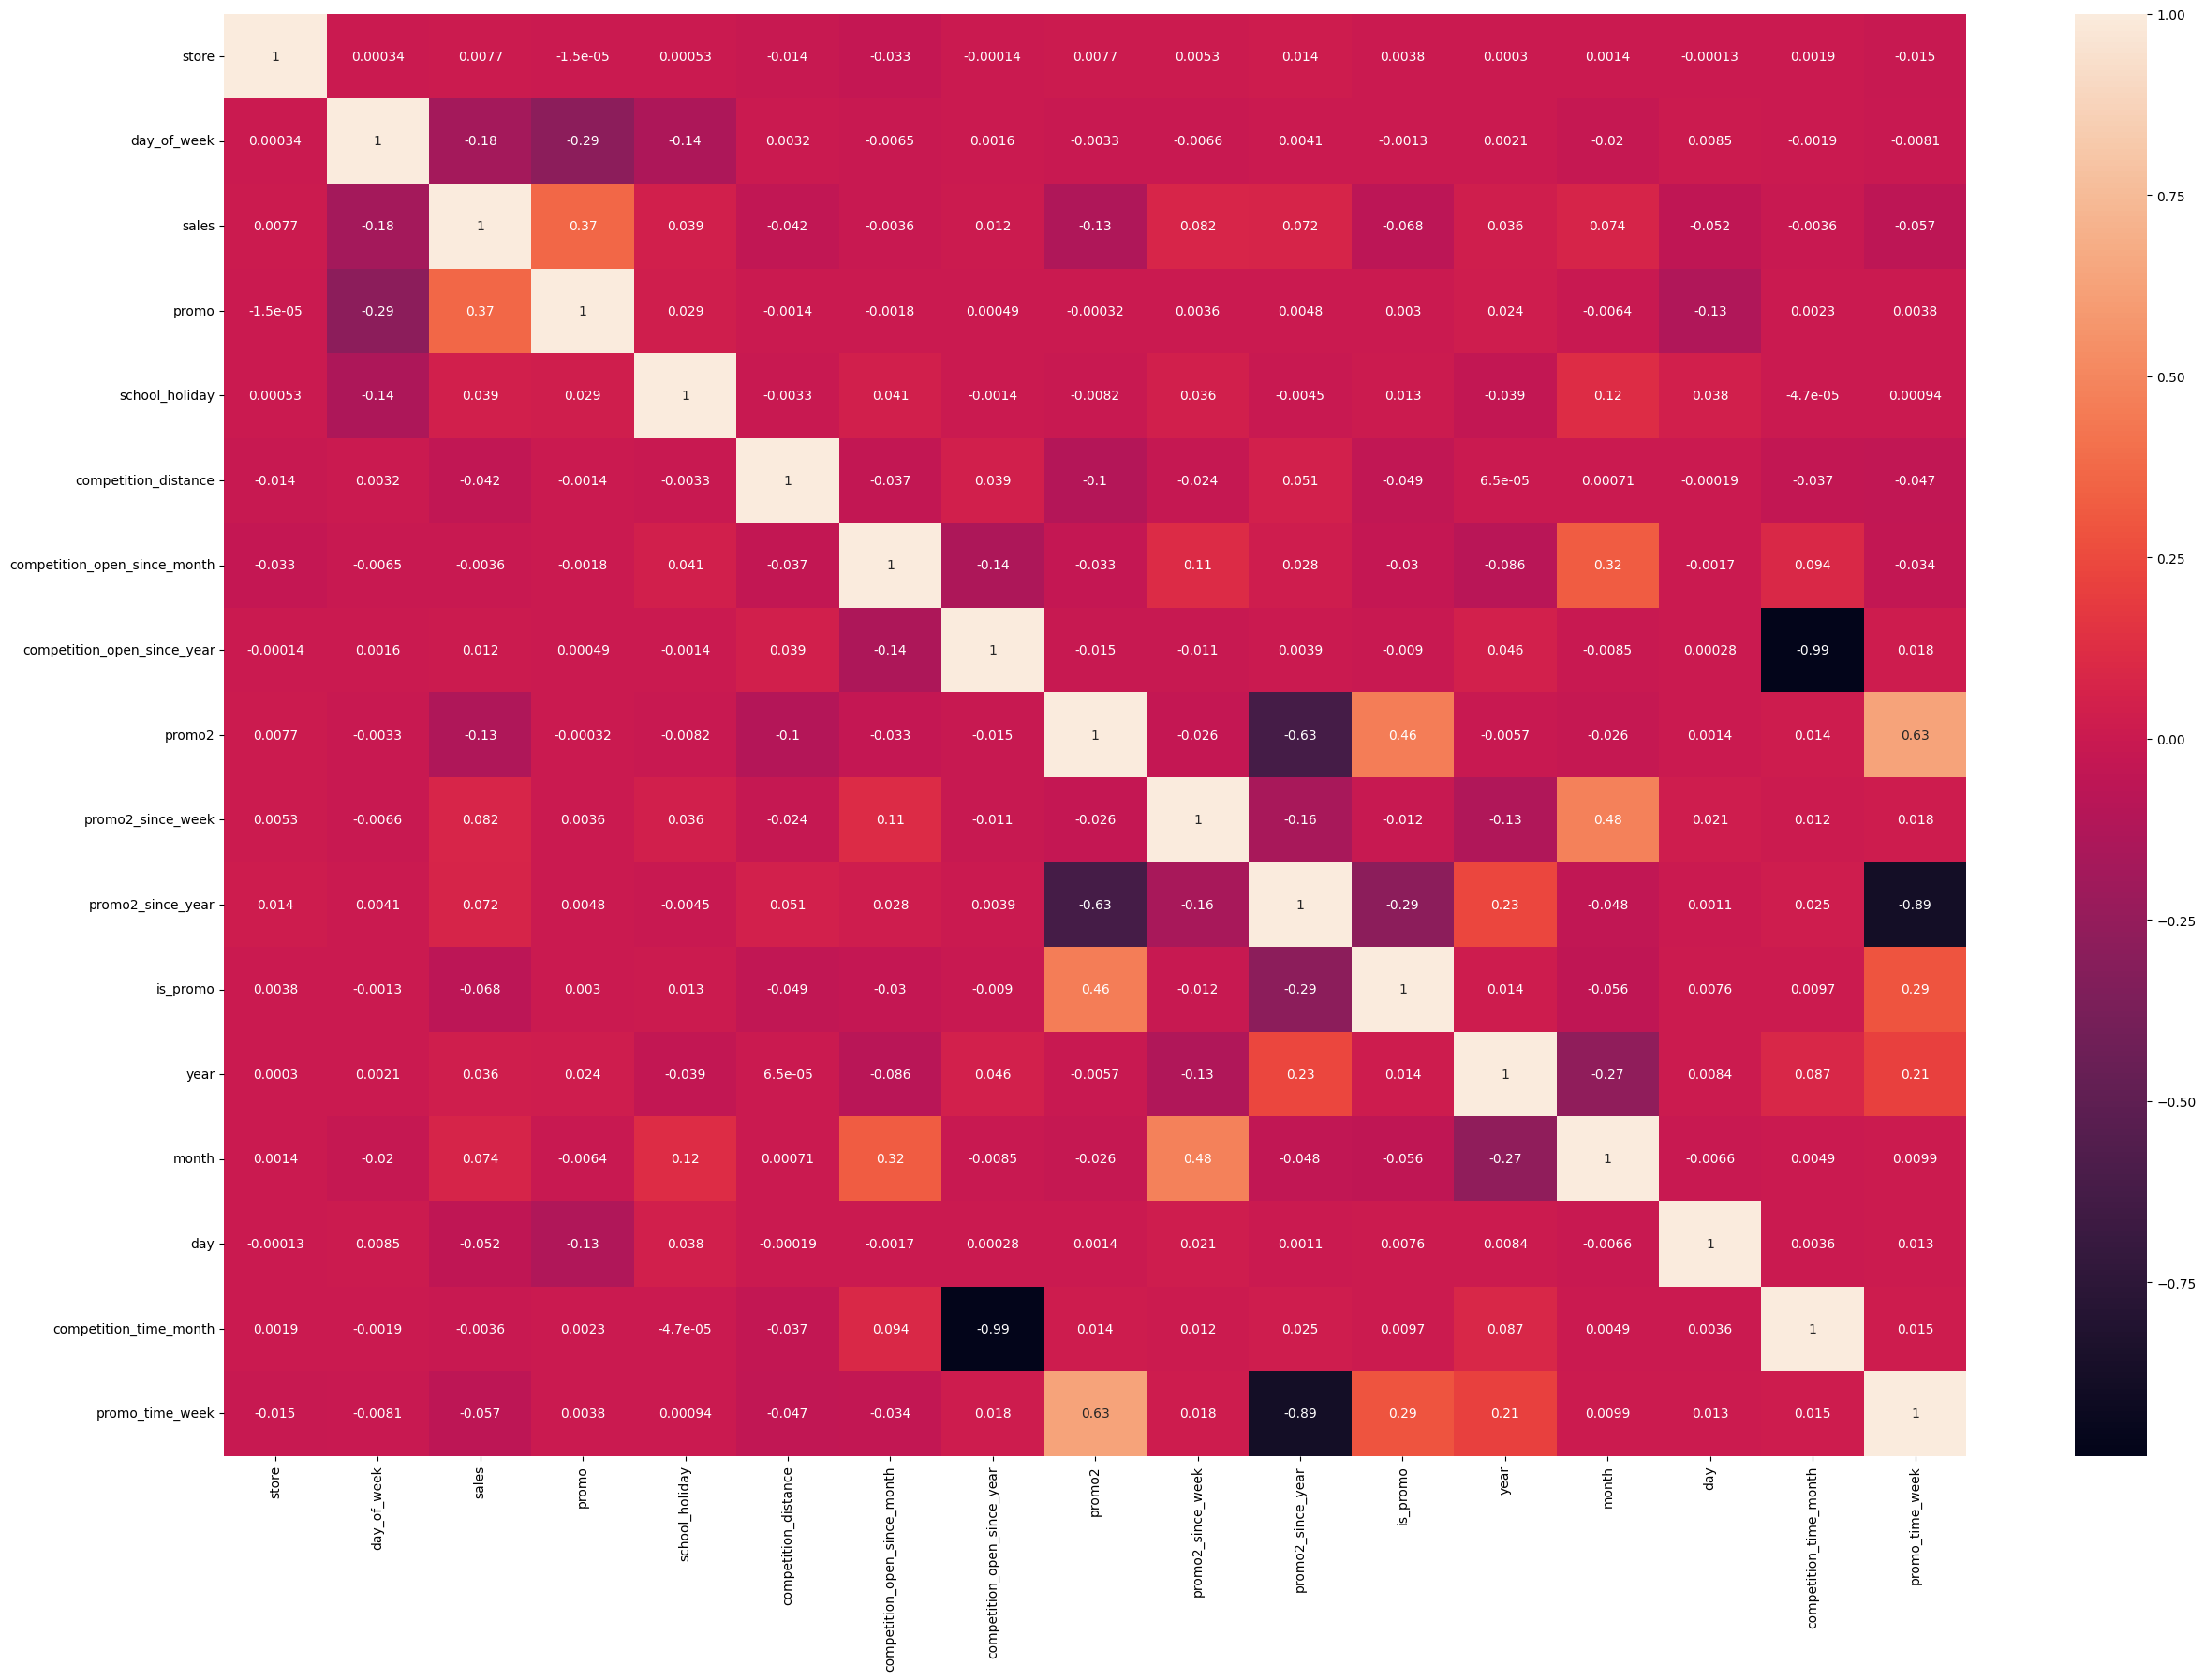

In [57]:
correlation = num_attributes1.corr(method='pearson')

plt.figure(figsize=(30,20))
sns.heatmap( correlation, annot=True );

### Categorical Attributes


<AxesSubplot:>

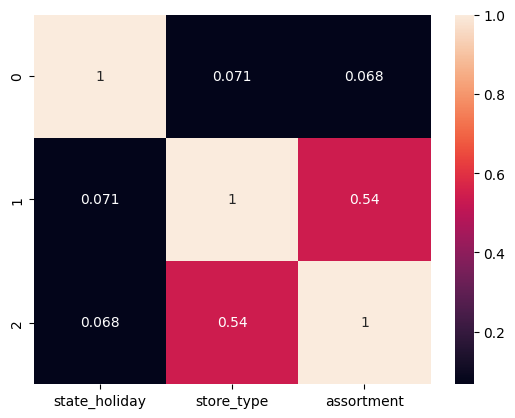

In [58]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset 
d = pd.DataFrame( { 'state_holiday': [a1, a2, a3], 
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9] })
d.set_index(d.columns)

sns.heatmap(d, annot=True)

# Passo5: DATA PREPARATION

In [59]:
df5 = df4.copy()

## Normalização

## Rescaling

In [60]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

#year
df5['year'] = mms.fit_transform(df5[['year']].values)

## Transformação

### Encoding

In [61]:
#state holiday - One Hot Encoding
df5=pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store type - Label Encoding
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])

#assortment - Ordinal Encoding
assortment_dict={'basic':1, 'extra':2, 'extended':3}
df5['assortment']=df5['assortment'].map(assortment_dict)


### Response Variable Transformation

In [62]:
# Transformação Logaritmica

df5['sales'] = np.log1p(df5['sales'])

### Nature Transformation

In [63]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52 ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30 ) ) )


# Passo6: FEATURES SELECTION

In [64]:
df6 = df5.copy()

## Split dataframe into training and test

In [65]:
cols_drop = ['day', 'month', 'week_of_year', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [66]:
df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [67]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}' )
print(f'Training Max Date: {X_train["date"].max()}' )
print(f'\nTest Min Date: {X_test["date"].min()}' )
print(f'Test Max Date: {X_test["date"].max()}' )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [ ]:
# training and test dataset for boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define Random Forest Regressor
#rf = RandomForestRegressor( n_jobs = -1 )

# define boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit( X_train_n, y_train_n)

## Best features from boruta


In [ ]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_slected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected from boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )


## Manual features selection

In [69]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )